[View in Colaboratory](https://colab.research.google.com/github/gmlander/Springboard/blob/master/Portfolio/Team_Composition_Analysis/Cluster_Feature_Autoencoders.ipynb)

# Autoencoding Positional Data
- Reducing dimensionality for cleaner unsupervised learning.

>[Autoencoding Positional Data](#scrollTo=N7WSaVUJhECr)

>>>>[Imports, Utilities, and Authentications](#scrollTo=yJbveaHaq1HK)

>>[Create Autoencoder for each position](#scrollTo=NnuYc8RlUId4)

>>>>[Create and Save Encoded Data](#scrollTo=mFDke8EqjMIO)



#### Imports, Utilities, and Authentications

**Connect to Google Drive**

In [0]:
# !kill -9 -1

In [2]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18298 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .../0

Setting up libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Setting up unattended-upgrades (0.98ubuntu1.1) ...

Creating config file /etc/apt/apt.conf.d/20auto-upgrades with new version

Creating config file /etc/apt/apt.conf.d/50unattended-upgrades with new version
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up dirmngr (2.1.15-1ubuntu8) ...
Setting up cron (3.0pl1-128ubuntu5) ...
Adding group `crontab' (GID 102) ...
Done.
update-rc.d: warning: start and stop actions are no longer supported; falling back to defaults
update-rc.d: warning: stop runlevel arguments (1) do not match cron Default-Stop values (none)
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Setting up kmod (24-1ubuntu2) ...
Setting up libdbus-glib-1-2:amd64 (0.108-2) ...
Setting up python3-gi (3.24.1-2build1) ...
Setting up module-init-tools (24-1ubuntu2) 

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

**Import Packages**

In [0]:
from __future__ import print_function
# from __future__ import absolute_import

import os, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

if not os.path.isfile('clr_callback.py'):
  !wget https://raw.githubusercontent.com/bckenstler/CLR/master/clr_callback.py
from clr_callback import CyclicLR

from keras.models import load_model, Sequential, Model
from keras.utils import Sequence, np_utils
from keras import backend as K
from keras.optimizers import Adam
from keras.layers import InputLayer, Input, Activation, Dense

import tensorflow as tf


**Utility Functions**

In [0]:
def unpickle(filename):
    p = open(filename,"rb")
    item = pickle.load(p)
    p.close()
    return item
    
def enpickle(python_object, filename):
    p = open(filename,"wb")
    pickle.dump(python_object, p)
    p.close()

**Change Directory**

In [0]:
os.chdir('drive/lol_autos/')

**Load Data**

In [0]:
dfs = unpickle('bin_scaled_pos_dfs.pickle')

In [12]:
dfs['Top'].head()

player league patchno  side position   champion  \
gameid  team                                                                   
1000029 SBENU Sonicboom        Soul    LCK    6.04  Blue      Top      Poppy   
        Jin Air Green Wings   TrAce    LCK    6.04   Red      Top    Trundle   
1000116 SBENU Sonicboom        Soul    LCK    6.04   Red      Top   Nautilus   
        CJ Entus             Untara    LCK    6.04  Blue      Top      Poppy   
1000306 Longzhu Gaming        Flame    LCK    6.04  Blue      Top  Gangplank   

                                ban1       ban2       ban3 ban4  \
gameid  team                                                      
1000029 SBENU Sonicboom        Corki  Gangplank  Lissandra  NaN   
        Jin Air Green Wings  Kalista       Lulu    Lee Sin  NaN   
1000116 SBENU Sonicboom      Kalista       Bard      Corki  NaN   
        CJ Entus             Nidalee    Lee Sin       Lulu  NaN   
1000306 Longzhu Gaming         Varus    Kalista       Lulu  NaN   

                                 ...       champ_xpat10  champ_xpdat10  \
gameid  team                     ...                                     
1000029 SBENU Sonicboom          ...           0.616161       0.064017   
        Jin Air Green Wings      ...          -0.215381       0.509503   
1000116 SBENU Sonicboom          ...          -0.340015      -0.514731   
        CJ Entus                 ...           0.616161       0.064017   
1000306 Longzhu Gaming           ...           0.615651       0.456839   

                             champ_result  champ_fbaron  champ_win_time  \
gameid  team                                                              
1000029 SBENU Sonicboom          0.514743      0.881612       -0.788123   
        Jin Air Green Wings      1.156143     -0.443453        0.931377   
1000116 SBENU Sonicboom         -0.110890     -0.173343       -0.251783   
        CJ Entus                 0.514743      0.881612       -0.788123   
1000306 Longzhu Gaming           0.244958      0.258832        1.324982   

                             champ_loss_time  champ_delay_need   rel_dmg  \
gameid  team                                                               
1000029 SBENU Sonicboom             0.497672         -0.793761  0.979171   
        Jin Air Green Wings        -1.451235          1.545827  0.774152   
1000116 SBENU Sonicboom            -0.475575          0.193271 -0.206715   
        CJ Entus                    0.497672         -0.793761 -0.992538   
1000306 Longzhu Gaming              0.242496          0.574517 -0.707632   

                             pick_meta  pick_off-meta  
gameid  team                                           
1000029 SBENU Sonicboom       1.631066       -0.50161  
        Jin Air Green Wings  -0.613096       -0.50161  
1000116 SBENU Sonicboom      -0.613096       -0.50161  
        CJ Entus              1.631066       -0.50161  
1000306 Longzhu Gaming       -0.613096       -0.50161  

[5 rows x 111 columns]

In [0]:
ref_feats = {}
for k in dfs:
    ref_feats[k] = ['pick_meta', 'pick_off-meta'] + [c for c in dfs[k].columns if 'champ_' in c]

## Create Autoencoder for each position

Goal is to reduce dimensionality while preserving as much original information as possible. So for this purpose, overfitting is not only acceptable, but encouraged. Only data used to train each autoencoder will be fed into them.

In [0]:
def get_encoder(data, encode_size = 15, n_epochs = 1000, verbose = False):
    num_feats = data.shape[1]

    # create layer blocks
    input_feats = Input(shape=(num_feats,))
    encoded = Dense(64, activation='relu')(input_feats)
    encoded = Dense(24, activation='relu')(encoded)
    encoded = Dense(encode_size, activation='relu')(encoded)
    decoded = Dense(24)(encoded)
    decoded = Dense(num_feats, activation='sigmoid')(decoded)
    
    # create models
    autoencoder = Model(input_feats, decoded)
    encoder = Model(input_feats, encoded)
    
    # fit on the autoencoder model
    autoencoder.compile(optimizer='Adam', loss='mean_absolute_error')

    history = autoencoder.fit(data, data,
                              epochs=n_epochs,
                              verbose = verbose,
                              batch_size=1000,
                              shuffle=True)
    return history, encoder

**Build Encoder For Each Position**

In [0]:
histories = {}
encoders = {}
for k, df in dfs.items():
    histories[k], encoders[k] = get_encoder(df[ref_feats[k]])

**Visualize Results**

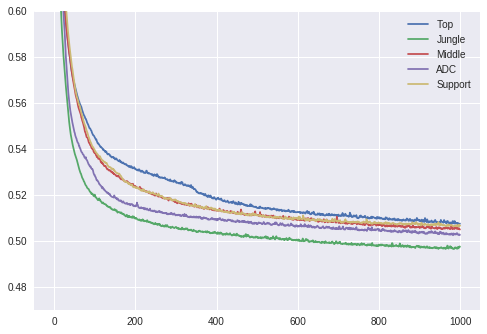

In [71]:
for k, h in histories.items():
    plt.plot(h.epoch, h.history['loss'], label = k)
plt.legend()
plt.ylim((.47,.6))
plt.show()

#### Create and Save Encoded Data

In [0]:
encoded_dfs = {}
for k, df in dfs.items():
    encoded_dfs[k] = pd.DataFrame(encoders[k].predict(df[ref_feats[k]]), index = df.index)

In [66]:
encoded_dfs['Top'].head()

0          1          2          3    4   \
gameid  team                                                                   
1000029 SBENU Sonicboom      12.565867   7.117973   4.085883   5.577287  0.0   
        Jin Air Green Wings  15.644508  19.294424  12.398015  12.151061  0.0   
1000116 SBENU Sonicboom      11.780732  13.262156   9.558178   8.227841  0.0   
        CJ Entus             12.565867   7.117973   4.085883   5.577287  0.0   
1000306 Longzhu Gaming        0.099965  19.479025  12.510785  17.105970  0.0   

                                    5          6          7          8   \
gameid  team                                                              
1000029 SBENU Sonicboom       1.734607   8.557325   2.450015   6.195940   
        Jin Air Green Wings  21.544254  14.444627  14.085790   4.780407   
1000116 SBENU Sonicboom       8.857267   8.518726   2.495687  10.321489   
        CJ Entus              1.734607   8.557325   2.450015   6.195940   
1000306 Longzhu Gaming        8.031336  25.155066   7.264550   0.000000   

                                   9          10        11         12  \
gameid  team                                                            
1000029 SBENU Sonicboom      3.180434   0.000000  2.143085   4.080381   
        Jin Air Green Wings  8.327134  18.006739  4.738669   8.472623   
1000116 SBENU Sonicboom      3.216353   3.685669  5.586344  11.608979   
        CJ Entus             3.180434   0.000000  2.143085   4.080381   
1000306 Longzhu Gaming       6.309029  14.681702  3.459881  12.586610   

                                   13        14  
gameid  team                                     
1000029 SBENU Sonicboom      6.147280  1.905619  
        Jin Air Green Wings  5.552164  1.388550  
1000116 SBENU Sonicboom      1.162263  6.930235  
        CJ Entus             6.147280  1.905619  
1000306 Longzhu Gaming       9.040486  4.570889

In [0]:
enpickle(encoded_dfs, 'encoded_dfs.pickle')

### Explore Clustering Results

In [0]:
val_tests = unpickle('cluster_validation_tests2.pickleb')

In [0]:
fair_clusts = []
for k,d in val_tests.items():
    for f,tests in d.items():
        if np.mean(tests['win_div']) <= .025:
            accs = []
            for clf in tests:
                if clf != 'win_div':
                    accs.append((clf, tests[clf]['accuracy_test']))
            acc = max(accs, key = lambda x: x[1])
            fair_clusts.append(('{}_{}_{}'.format(k,f,acc[0]),acc[1], np.mean(tests['win_div'])))
            
method, accuracy, win_div = zip(*fair_clusts)
clusters = pd.DataFrame({'method':method, 'accuracy':accuracy, 'win_div':win_div})

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


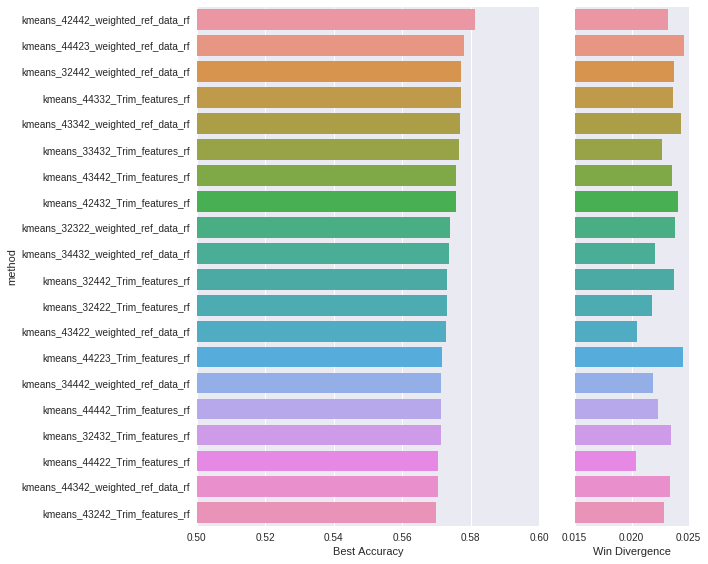

In [138]:
# %%capture --no-stdout
fig, ax = plt.subplots(1,2, figsize=(10,8), sharey = True, gridspec_kw = {'width_ratios':[3, 1]})
sns.barplot(y='method', x='accuracy', data = clusters.sort_values(by='accuracy',ascending=False).head(20), orient='h',ax=ax[0])
ax[0].set_xlabel('Best Accuracy')
ax[0].set_xlim((.5,.6))
sns.barplot(y='method', x='win_div', data = clusters.sort_values(by='accuracy',ascending=False).head(20), orient='h',ax=ax[1])
ax[1].set_ylabel('')
ax[1].set_xlabel('Win Divergence')
ax[1].set_xlim((.015,.025))
plt.tight_layout()
plt.show()

# fig.savefig('cluster-bars.png', dpi=fig.dpi, bbox_inches='tight')

### HDBSCAN with KNN

In [0]:
val_tests = unpickle('cluster_validation_tests_hdb.pickle')
fair_clusts = []
for k,d in val_tests.items():
    for f,tests in d.items():
        if np.mean(tests['win_div']) <= .095:
            accs = []
            for clf in tests:
                if clf != 'win_div':
                    accs.append((clf, tests[clf]['accuracy_test']))
            acc = max(accs, key = lambda x: x[1])
            fair_clusts.append(('{}_{}_{}'.format(k,f,acc[0]),acc[1], np.mean(tests['win_div'])))
            
method, accuracy, win_div = zip(*fair_clusts)
clusters = pd.DataFrame({'method':method, 'accuracy':accuracy, 'win_div':win_div})

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


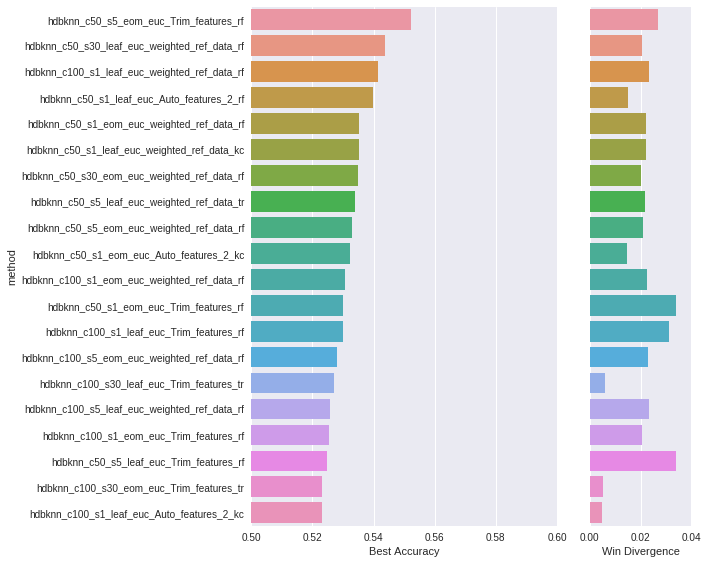

In [144]:

# %%capture --no-stdout
fig, ax = plt.subplots(1,2, figsize=(10,8), sharey = True, gridspec_kw = {'width_ratios':[3, 1]})
sns.barplot(y='method', x='accuracy', data = clusters.sort_values(by='accuracy',ascending=False).head(20), orient='h',ax=ax[0])
ax[0].set_xlabel('Best Accuracy')
ax[0].set_xlim((.5,.6))
sns.barplot(y='method', x='win_div', data = clusters.sort_values(by='accuracy',ascending=False).head(20), orient='h',ax=ax[1])
ax[1].set_ylabel('')
ax[1].set_xlabel('Win Divergence')
ax[1].set_xlim((.0,.04))
plt.tight_layout()
plt.show()

# fig.savefig('cluster-bars.png', dpi=fig.dpi, bbox_inches='tight')